# Introducción a las redes neuronales con ejemplos numéricos

------------------------------------

## 1. Diagrama general del aprendizajo supervisado en ML

![title](https://raw.githubusercontent.com/igomezv/neural_nets_utilities/master/Tutorial_Journal_Club/figures/aprendizajesupervizado.png)

## 2. ¿Qué es una red neuronal?

Según Wiki: es un modelo computacional vagamente inspirado en el comportamiento observado en su homólogo biológico.

* Numeros inicialmente aleatorios $\in (-1,1)$ asociados a cada conexión (llamados pesos) hacen alusión a la sinapsis.
 
* Cada nodo de la RNA también es llamada neurona.
 
* Hay una función de activación que determina si las señales activan o no cierta respuesta.
 
* Las RNA procesan señales en paralelo.

### 2.1 Propagación hacia adelante:

- Genera pesos y bias aleatorios.
- Las entradas de la capa anterior se multiplican por los pesos por medio de una suma ponderada.
- Al resultado de la suma ponderada se le aplica una función de activación.
- La red neuronal arroja una predicción.

<div>
    <img src="https://raw.githubusercontent.com/igomezv/neural_nets_utilities/master/Tutorial_Journal_Club/figures/ANN_.png" width="500">
</div>

### 2.2 Tipos de funciones de activación:
Fuente: https://mlfromscratch.com/activation-functions-explained/#/
![title](https://mlfromscratch.com/content/images/2019/12/activation-functions.gif)

Tómese en cuenta lo siguiente.

- Los bias y pesos son inicialmente aleatorios, pero de alguna manera se deben ajustar mediante iteraciones.
- Cada conexión tiene un peso.
- Cada neurona tiene un bias. 

### 2.3 ¿Qué hace falta?
- Se requiere una métrica que mida qué tan cerca o lejos del valor esperado son las predicciones de la red (función de costo o de pérdida).
- Es necesario un algoritmo que minimize la función anterior.
- Si no se emplea una función de activación no lineal, la suma ponderada y toda la estructura de la red solamente proveerán transformaciones lineales.


Consíderese lo siguiente:


- Función de costo: 
$C(w, b) ≡ \frac{1}{2} \Sigma_x || y(x) − a(x,w,b)||^2$, donde a es la predicción de la RNA.
- Métodos analíticos de minimización no son útiles para muchas variables.
- Se requiere un algoritmo para minimizar la función de costo: descenso del gradiente.
- El descenso del gradiente únicamente calcula gradientes, es el más simple de toda una familia de algoritmos de minimización.

### 2.4 Descenso del gradiente (intuición)

- La deducción no es propósito de esta notebook, pero cada nuevo paso en busca de la minimización de la función de costo, obedece la siguiente regla:

$ v -> v' = v - \eta \nabla C$, donde $v$ es $f(w, b)$ y $\eta$ la tasa de aprendizaje (tamaño de paso, learning rate)

- Se da un paso en dirección opuesta al gradiente hasta minimizar la función de costo.

- Se le llama *backpropagation* al algoritmo que realiza esto iterativamente desde la última capa hasta la primera.

Fuente: https://kevinbinz.com/2019/05/26/intro-gradient-descent/

![title](https://kevinbinz.files.wordpress.com/2019/05/dualspace_explore.gif)

- Se quiere encontrar (x,y) tal que sea un mínimo en la superficie (función de costo).

Fuente: https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c

![title](https://miro.medium.com/max/819/1*hUd744hDEEGx0-ypWGhrkw.gif)

### 2.5 Algunos tipos de redes neuronales
Fuente: https://www.asimovinstitute.org/neural-network-zoo/
<div>
    <img src="https://www.asimovinstitute.org/wp-content/uploads/2019/04/NeuralNetworkZoo20042019.png", width="500">
</div>

## 3. Construyamos una red neuronal configurable con keras

In [13]:
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [2]:
class neural_net:
    def __init__(self, X, Y, topology, epochs=50, lr=0.0001, bs=4, early_tol=100, scale=False):
        self.topology = topology
        self.epochs = epochs
        self.lr = lr
        self.bs = bs
        self.early_tol = early_tol
        self.scale = scale
    
        ntrain = int(0.8* len(X))
        indx = [ntrain]
        self.X_train, self.X_test = np.split(X, indx)
        self.Y_train, self.Y_test = np.split(Y, indx)
        
        if self.scale:
            self.scaler = StandardScaler()
            try:
                self.scaler.fit(X)
                self.X_train = self.scaler.transform(self.X_train)
                self.X_test = self.scaler.transform(self.X_test)
            except:
                self.scaler.fit(X.reshape(-1,1))
                self.X_train = self.scaler.transform(self.X_train.reshape(-1,1))
                self.X_test = self.scaler.transform(self.X_test.reshape(-1,1))

            self.X_train = self.scaler.transform(self.X_train)
            self.X_test = self.scaler.transform(self.X_test)
        
        self.model = self.model()
        self.model.summary()
        
    def model(self):
        # Red neuronal
        model = K.models.Sequential()
        # Hidden layers

        for i, nodes in enumerate(self.topology):
            if i == 0:
                model.add(K.layers.Dense(self.topology[1], input_dim=self.topology[0], activation='relu'))
            elif i < len(self.topology)-2:
                model.add(K.layers.Dense(self.topology[i+1], activation='relu'))
            else:
                model.add(K.layers.Dense(self.topology[i], activation='relu'))
        optimizer = K.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        
        return model                    
    
    def train(self):
        callbacks = [K.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                               min_delta=0.0,
                                               patience=self.early_tol,
                                               restore_best_weights=True)]
        print("Entrenando, por favor, espera...")
        self.history = self.model.fit(self.X_train,
                                      self.Y_train,
                                      validation_data=(self.X_test,
                                                       self.Y_test),
                                      epochs=self.epochs, batch_size=self.bs,
                                      callbacks=callbacks, verbose=0)
        print("¡Entrenamiento terminado!")
        return self.history
    
    def get_w_and_b(self, nlayer):
        weights, biases = self.model.layers[nlayer].get_weights()
        return weights, biases
    
    def predict(self, x):
        if type(x) == type([1]):
            x = np.array(x)
        if type(x) == type(1):
            x = np.array([x])
        if self.scale:
            try:
                x = self.scaler.transform(x)
            except:
                x = self.scaler.transform(x.reshape(-1,1))
        return self.model.predict(x)
        
    def plot(self):
        plt.plot(self.history.history['loss'], label='training set')
        plt.plot(self.history.history['val_loss'], label='validation set')
        mse = np.min(self.history.history['val_loss'])
        plt.title('MSE: {} Uncertainty: {}'.format(mse, np.sqrt(mse)))
        plt.ylabel('loss function')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        

## 4. Ejemplos numéricos

### 4.1 Ejemplo 1: Aprendiendo funciones

#### Analicemos si una red neuronal puede aprender las siguientes tres funciones:

* $line(x) = 2x+3$
* $quadratic(x) = x^2 +2$
* $quadtres(x_1,x_2,x_3) = x_1^2 + 2x_2 + x_3$

In [3]:
def line(x):
    return 2*x + 3 + 0.05 * np.random.rand()

def quadratic(x):
    return x**2 + 2 + 0.001 * np.random.rand()

def quadtres(x):
    y = np.zeros(len(x))
    for i in range(len(x)):
        y[i] = x[i, 0]**2 + 2*x[i, 1] + x[i, 2]
    return y

In [4]:
# Descomentar función para generar datos
# fn = line
fn = quadratic
# fn = quadtres

# Seleccionar número de puntos para el dataset
npoints = 100

# Generar X
## para line y quadratic
X = np.random.rand(npoints)
## para quadtres
# X = np.random.rand(npoints, 3)

# Generar Y
Y = fn(X)

# Ver tabla de datos
## para line y quadratic
data =pd.DataFrame(zip(X,Y), columns=['x', 'y'])
## para quadtres
# data =pd.DataFrame(zip(X[:,0], X[:,1], X[:,2], Y), columns=['$x_1$', '$x_2$', '$x_3$', 'y'])
data.head(10)

,x,y
0,0.690611,0.477934
1,0.388933,0.152260
2,0.692010,0.479869
3,0.844968,0.714962
4,0.939549,0.883743
5,0.604592,0.366523
6,0.800057,0.641082
7,0.482023,0.233337
8,0.607142,0.369613
9,0.997328,0.995654


In [5]:
network = neural_net(X, Y, [1,100,1], epochs=100, bs=16, lr=0.01, scale=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________


In [6]:
network.train()

Entrenando, por favor, espera...
¡Entrenamiento terminado!


In [7]:
w, b = network.get_w_and_b(nlayer=0)
print(len(w), len(b))
print(w)

1 100
[[ 0.09772065 -0.0280372  -0.18533267  0.16927557  0.09565057  0.1517739
  -0.19979484  0.16403805 -0.10642112  0.14263816 -0.08693132 -0.03227205
  -0.21524195  0.13857958 -0.21694283  0.21257149 -0.15632048  0.06629022
  -0.08176262 -0.14292893  0.24060781  0.12015954  0.03569694  0.13221182
  -0.01240145 -0.2210431   0.03891002  0.17196397  0.09450796  0.00462745
   0.09786277 -0.00986721  0.18633386  0.09461764  0.21013026  0.23443055
   0.18835574 -0.104336   -0.19821055  0.02541066 -0.11152012  0.08104762
  -0.18482475 -0.15930487 -0.10997772 -0.050305   -0.14136325 -0.18365806
  -0.15839675 -0.18501005  0.17285898  0.23247255 -0.10069915 -0.01194788
  -0.00520809 -0.02396286 -0.02275304 -0.18412638 -0.2112079  -0.14559415
  -0.024582   -0.17193082 -0.03689864 -0.05511582 -0.17128852 -0.1818731
   0.2398211  -0.2155473  -0.14610533  0.02672989 -0.15713799 -0.24133639
   0.06073857 -0.09534061 -0.17471406 -0.12292019 -0.24251616 -0.02045798
   0.24041316  0.18223809  0.06469

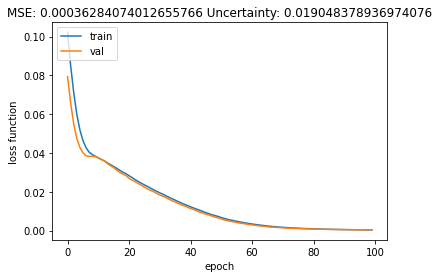

In [8]:
network.plot()

In [9]:
# new_vector = np.array([0.7, 0.5, 0.6]).reshape(1,3)
new_vector = np.array([0.7])
prediction = network.predict(new_vector)


print("Valor real: {}".format(float(fn(new_vector))))
print("Predicción: {}".format(float(prediction)))

Valor real: 0.49029552571051266
Predicción: 0.4558666944503784


In [10]:
from time import time
from scipy import integrate

### 4.2 Ejemplo 2: Ahorrando tiempo de cómputo

#### Experimento con alguna integral doble arbitraria con parámetros a, b:

$\int^1_0 \int^1_0 \sqrt{x^2 + y^2+ a^2} + b\frac{xy}{2}dx dy$

#### Analicemos si una red neuronal puede aprender a calcular esta integral y ahorrar tiempo cuando se requiere evaluar múltiples veces.

In [26]:
def f(x, y, a, b):
    return np.sqrt(x**2 + y**2 + a**2) + b*0.5*x*y 

t1 = time()
i = integrate.dblquad(f, 0, 1, lambda x: 0, lambda x: 1, args=([0.1, 0.2]))
print(i[0])
print("Tiempo: {:.4f} segundos".format(time()-t1))

0.7985035067551794
Tiempo: 0.0014 segundos


In [66]:
npoints = 10000
ab_points = np.random.rand(npoints, 2)
integrals = np.zeros(npoints)

t1 = time()
for i in range(npoints):
    a = ab_points[i, 0]
    b = ab_points[i, 1]
    integ, _ = integrate.dblquad(f, 0, 1, lambda x: 0, lambda x: 1, args=([a, b]))
    integrals[i] = integ
t = time()-t1

print("Tiempo: {:.5f} segundos".format(t))
h = pd.DataFrame(zip(ab_points[:,0], ab_points[:,1], integrals), columns=['a', 'b', 'integral'])
h.head()

Tiempo: 14.36328 segundos


,a,b,integral
0,0.695699,0.406552,1.105280
1,0.889975,0.904292,1.308280
2,0.613300,0.370071,1.046025
3,0.198064,0.835642,0.900429
4,0.509632,0.254339,0.968124


In [54]:
network = neural_net(ab_points, integrals, [2, 100, 1], epochs=100, bs=16, lr=0.01, scale=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 10,501
Trainable params: 10,501
Non-trainable params: 0
_________________________________________________________________


In [55]:
network.train()


Entrenando, por favor, espera...
¡Entrenamiento terminado!


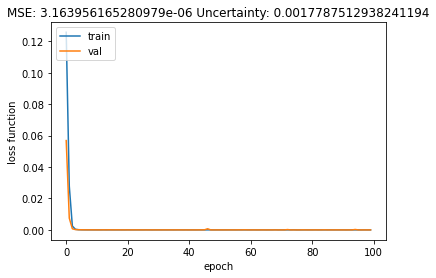

In [56]:
network.plot()

In [69]:
npoints = 10000
ab_points = np.random.rand(npoints, 2)
integrals = np.zeros(npoints)

t1 = time()
predictions = network.predict(ab_points)
t = time()-t1
print("Tiempo: {:.5f} segundos".format(t))
print(np.shape(predictions))
h = pd.DataFrame(zip(ab_points[:,0], ab_points[:,1], predictions), columns=['a', 'b', 'integral'])
h.head()

Tiempo: 0.11484 segundos
(10000, 1)


,a,b,integral
0,0.317076,0.492332,[1.0563533]
1,0.515759,0.372255,[1.0920751]
2,0.228102,0.794891,[1.0596257]
3,0.329806,0.323634,[1.0606221]
4,0.578606,0.729660,[1.1211824]


In [68]:
# Probemos un valor al azar
a = 0.751548
b = 0.458467
integ, _ = integrate.dblquad(f, 0, 1, lambda x: 0, lambda x: 1, args=([a, b]))
print(integ)

1.150683917251989


#### Este mecanismo se puede utilizar para aprender la función de likelihood, la cual se evalúa miles de veces, dentro de un proceso de inferencia Bayesiana.
<div>
    <img src="https://raw.githubusercontent.com/igomezv/neural_nets_utilities/master/Tutorial_Journal_Club/figures/ann.png" width="500">
</div>

<div>
    <img src="https://raw.githubusercontent.com/igomezv/neural_nets_utilities/master/Tutorial_Journal_Club/figures/uamresults.png" width="500">
</div>
                                                                                                                            
                                                                                                                           

### 4. 3: Modelemos unos datos cosmológicos

#### Utilicemos la compilación Union 2.1 para ver si la red neuronal puede  modelar sus datos y sus errores.

#### Idea general:
<div>
<img src="https://raw.githubusercontent.com/igomezv/neural_nets_utilities/master/Tutorial_Journal_Club/figures/annHz.png" width="300"/>
</div>



In [85]:
file = 'https://raw.githubusercontent.com/igomezv/neural_nets_utilities/master/Tutorial_Journal_Club/data/Union2.1_DL.txt'
data =pd.read_csv(file, sep=' ', names=['z','$D_L(z)$','error'])
data.head()

,z,$D_L(z)$,error
0,0.0150,61.659500,5.111145
1,0.0150,66.374307,6.418965
2,0.0150,67.920363,5.004557
3,0.0150,75.162289,7.614973
4,0.0151,80.537844,7.788700


<ErrorbarContainer object of 3 artists>

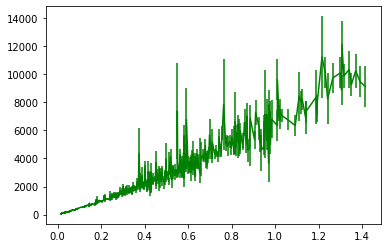

In [115]:
plt.errorbar(data['z'], data['$D_L(z)$'], yerr = data['error'], c='g')

In [116]:
X = data['z'].values
Y = data[['$D_L(z)$', 'error']].values
network = neural_net(X, Y, topology=[1, 500, 500, 2], scale=True)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 500)               1000      
_________________________________________________________________
dense_27 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_28 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 1002      
Total params: 503,002
Trainable params: 503,002
Non-trainable params: 0
_________________________________________________________________


Entrenando, por favor, espera...
¡Entrenamiento terminado!


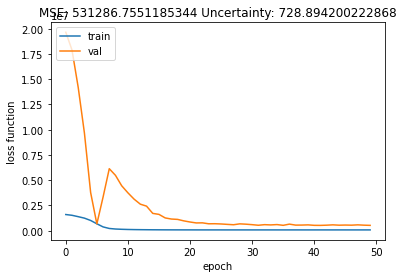

In [117]:
network.train()
network.plot()

<ErrorbarContainer object of 3 artists>

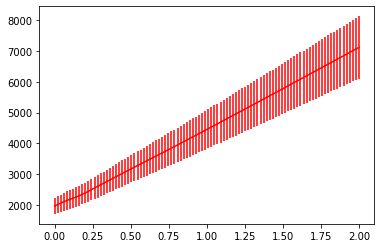

In [119]:
fake_z = np.linspace(0, 2, 100)
fake_dl = network.predict(fake_z)
plt.errorbar(fake_z, fake_dl[:,0], yerr=fake_dl[:, 1], c='r')
# plt.errorbar(data['z'], data['$D_L(z)$'], yerr = data['error'], c ='g')